In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import json
import joblib 

# Set random seed for reproducibility
np.random.seed(42)

In [4]:
def load_and_prepare_data(feather_path):
    """Load the data file and extract abstracts with all flags"""
    try:
        df = pd.read_feather(feather_path)
        
        # Filter out rows with NaN abstracts from either provider
        valid_df = df.dropna(subset=['groq_abstract', 'ollama_abstract'])
        
        # Extract abstracts and their metadata
        groq_abstracts = valid_df['groq_abstract'].tolist()
        ollama_abstracts = valid_df['ollama_abstract'].tolist()
        prompt_ids = valid_df['id'].tolist()
        
        # Extract flag information for both providers
        groq_forbidden = valid_df['groq_contains_forbidden_words'].tolist()
        ollama_forbidden = valid_df['ollama_contains_forbidden_words'].tolist()
        
        # Convert string representations to Python objects
        groq_subtopics = []
        ollama_subtopics = []
        for _, row in valid_df.iterrows():
            # Handle potential string representation of dictionaries
            if isinstance(row.get('groq_contains_subtopics'), str):
                groq_subtopics.append(json.loads(row['groq_contains_subtopics'].replace("'", '"')))
            else:
                groq_subtopics.append(row.get('groq_contains_subtopics', {}))
                
            if isinstance(row.get('ollama_contains_subtopics'), str):
                ollama_subtopics.append(json.loads(row['ollama_contains_subtopics'].replace("'", '"')))
            else:
                ollama_subtopics.append(row.get('ollama_contains_subtopics', {}))
        
        groq_any_subtopic = valid_df['groq_any_subtopic_present'].tolist()
        ollama_any_subtopic = valid_df['ollama_any_subtopic_present'].tolist()
        
        # Selected subtopics for reference
        selected_subtopics = []
        for _, row in valid_df.iterrows():
            if isinstance(row.get('selected_subtopics'), str):
                selected_subtopics.append(json.loads(row['selected_subtopics'].replace("'", '"')))
            else:
                selected_subtopics.append(row.get('selected_subtopics', {}))
        
        # Create lists for tracking abstracts and their metadata
        abstract_texts = groq_abstracts + ollama_abstracts
        abstract_sources = ['groq'] * len(groq_abstracts) + ['ollama'] * len(ollama_abstracts)
        abstract_prompt_ids = prompt_ids * 2
        abstract_forbidden = groq_forbidden + ollama_forbidden
        abstract_any_subtopic = groq_any_subtopic + ollama_any_subtopic
        
        # Create a mapping to identify pairs from the same prompt
        same_prompt_map = {}
        for i in range(len(groq_abstracts)):
            groq_index = i
            ollama_index = i + len(groq_abstracts)
            same_prompt_map[groq_index] = ollama_index
            same_prompt_map[ollama_index] = groq_index
        
        print(f"Loaded {len(groq_abstracts)} paired abstracts from {len(prompt_ids)} prompts")
        
        # Return all data including the new flags
        metadata = {
            'abstract_texts': abstract_texts,
            'abstract_sources': abstract_sources,
            'abstract_prompt_ids': abstract_prompt_ids,
            'abstract_forbidden': abstract_forbidden,
            'abstract_any_subtopic': abstract_any_subtopic,
            'groq_subtopics': groq_subtopics,
            'ollama_subtopics': ollama_subtopics,
            'selected_subtopics': selected_subtopics,
            'same_prompt_map': same_prompt_map
        }
        
        return metadata
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [32]:
def embed_abstracts(abstract_texts, model_name="all-MiniLM-L6-v2"):
    """Embed abstracts using a sentence transformer model"""
    try:
        print(f"Loading model: {model_name}")
        model = SentenceTransformer(model_name)
        
        print("Embedding abstracts...")
        embeddings = model.encode(abstract_texts, show_progress_bar=True, 
                                  batch_size=8, convert_to_tensor=True)
        
        # Convert to numpy for easier manipulation
        if isinstance(embeddings, torch.Tensor):
            embeddings = embeddings.cpu().numpy()
            
        print(f"Generated embeddings with shape: {embeddings.shape}")
        return embeddings
    except Exception as e:
        print(f"Error embedding abstracts: {str(e)}")
        return None

def compute_similarities(embeddings):
    """Compute cosine similarity between all pairs of embeddings"""
    try:
        print("Computing similarity matrix...")
        similarity_matrix = cosine_similarity(embeddings)
        print(f"Similarity matrix shape: {similarity_matrix.shape}")
        return similarity_matrix
    except Exception as e:
        print(f"Error computing similarities: {str(e)}")
        return None

def analyze_flag_statistics(metadata):
    """Analyze statistics related to forbidden words and subtopics"""
    try:
        # Extract data from metadata
        abstract_sources = metadata['abstract_sources']
        abstract_forbidden = metadata['abstract_forbidden']
        abstract_any_subtopic = metadata['abstract_any_subtopic']
        groq_count = abstract_sources.count('groq')
        
        # Calculate statistics
        print("\nFlag Statistics:")
        
        # Forbidden words statistics
        groq_forbidden = abstract_forbidden[:groq_count]
        ollama_forbidden = abstract_forbidden[groq_count:]
        print(f"Groq abstracts with forbidden words: {sum(groq_forbidden)} ({sum(groq_forbidden)/len(groq_forbidden)*100:.1f}%)")
        print(f"Ollama abstracts with forbidden words: {sum(ollama_forbidden)} ({sum(ollama_forbidden)/len(ollama_forbidden)*100:.1f}%)")
        
        # Subtopic presence statistics
        groq_subtopic = abstract_any_subtopic[:groq_count]
        ollama_subtopic = abstract_any_subtopic[groq_count:]
        print(f"Groq abstracts with any subtopic: {sum(groq_subtopic)} ({sum(groq_subtopic)/len(groq_subtopic)*100:.1f}%)")
        print(f"Ollama abstracts with any subtopic: {sum(ollama_subtopic)} ({sum(ollama_subtopic)/len(ollama_subtopic)*100:.1f}%)")
        
        # Conditional probabilities
        groq_subtopic_given_forbidden = [s for f, s in zip(groq_forbidden, groq_subtopic) if f]
        ollama_subtopic_given_forbidden = [s for f, s in zip(ollama_forbidden, ollama_subtopic) if f]
        
        if groq_subtopic_given_forbidden:
            print(f"P(subtopic | forbidden) for Groq: {sum(groq_subtopic_given_forbidden)/len(groq_subtopic_given_forbidden):.3f}")
        else:
            print("No Groq abstracts with forbidden words to calculate conditional probability")
            
        if ollama_subtopic_given_forbidden:
            print(f"P(subtopic | forbidden) for Ollama: {sum(ollama_subtopic_given_forbidden)/len(ollama_subtopic_given_forbidden):.3f}")
        else:
            print("No Ollama abstracts with forbidden words to calculate conditional probability")
            
        # Create data for visualization
        flag_data = {
            'Provider': ['Groq']*len(groq_forbidden) + ['Ollama']*len(ollama_forbidden),
            'Forbidden': groq_forbidden + ollama_forbidden,
            'Subtopic': groq_subtopic + ollama_subtopic
        }
        
        return flag_data
    except Exception as e:
        print(f"Error analyzing flag statistics: {str(e)}")
        return None

def plot_same_vs_different_prompt_similarity(similarity_matrix, metadata):
    """Create enhanced scatterplot to visualize same-prompt vs. different-prompt similarities"""
    try:
        # Extract data from metadata
        abstract_sources = metadata['abstract_sources']
        abstract_forbidden = metadata['abstract_forbidden']
        abstract_any_subtopic = metadata['abstract_any_subtopic']
        same_prompt_map = metadata['same_prompt_map']
        
        # Get dimensions
        n_abstracts = len(abstract_sources)
        groq_count = abstract_sources.count('groq')
        
        # Extract similarities and track flags
        same_prompt_data = {'similarity': [], 'both_forbidden': [], 'both_subtopic': []}
        different_prompt_data = {
            'similarity': [], 'provider_pair': [], 'both_forbidden': [], 'both_subtopic': []
        }
        
        # Same prompt pairs
        for i in range(groq_count):
            ollama_idx = groq_count + i
            sim = similarity_matrix[i, ollama_idx]
            both_forbidden = abstract_forbidden[i] and abstract_forbidden[ollama_idx]
            both_subtopic = abstract_any_subtopic[i] and abstract_any_subtopic[ollama_idx]
            
            same_prompt_data['similarity'].append(sim)
            same_prompt_data['both_forbidden'].append(both_forbidden)
            same_prompt_data['both_subtopic'].append(both_subtopic)
        
        # Different prompt pairs within providers and cross-provider
        for i in range(n_abstracts):
            for j in range(n_abstracts):
                if i != j and j != same_prompt_map.get(i, -1):  # Different abstract, different prompt
                    sim = similarity_matrix[i, j]
                    both_forbidden = abstract_forbidden[i] and abstract_forbidden[j]
                    both_subtopic = abstract_any_subtopic[i] and abstract_any_subtopic[j]
                    
                    # Determine provider pair
                    if i < groq_count and j < groq_count:
                        provider_pair = 'Groq-Groq'
                    elif i >= groq_count and j >= groq_count:
                        provider_pair = 'Ollama-Ollama'
                    else:
                        provider_pair = 'Cross-Provider'
                    
                    different_prompt_data['similarity'].append(sim)
                    different_prompt_data['provider_pair'].append(provider_pair)
                    different_prompt_data['both_forbidden'].append(both_forbidden)
                    different_prompt_data['both_subtopic'].append(both_subtopic)
        
        # Convert to DataFrames
        same_df = pd.DataFrame(same_prompt_data)
        diff_df = pd.DataFrame(different_prompt_data)
        
        # Create multi-plot figure
        fig, axes = plt.subplots(2, 1, figsize=(12, 14))
        
        # 1. Basic similarity distribution
        sns.boxplot(x=['Same Prompt']*len(same_df) + diff_df['provider_pair'].tolist(), 
                   y=same_df['similarity'].tolist() + diff_df['similarity'].tolist(),
                   ax=axes[0])
        
        axes[0].set_title('Similarity Distribution: Same vs. Different Prompts', fontsize=14)
        axes[0].set_ylabel('Cosine Similarity', fontsize=12)
        axes[0].set_xlabel('')
        axes[0].grid(True, alpha=0.3)
        
        # Add statistics as text
        axes[0].text(0.05, 0.05, 
                    f"Same Prompt: μ={np.mean(same_df['similarity']):.3f}, σ={np.std(same_df['similarity']):.3f}\n" +
                    f"Diff (Groq-Groq): μ={diff_df[diff_df['provider_pair']=='Groq-Groq']['similarity'].mean():.3f}\n" +
                    f"Diff (Ollama-Ollama): μ={diff_df[diff_df['provider_pair']=='Ollama-Ollama']['similarity'].mean():.3f}\n" +
                    f"Diff (Cross): μ={diff_df[diff_df['provider_pair']=='Cross-Provider']['similarity'].mean():.3f}",
                    transform=axes[0].transAxes,
                    bbox=dict(facecolor='white', alpha=0.7))
        
        # 2. Similarity by flag conditions
        # Create combinations of flag conditions
        same_df['condition'] = 'Neither'
        same_df.loc[same_df['both_forbidden'] & ~same_df['both_subtopic'], 'condition'] = 'Forbidden Only'
        same_df.loc[~same_df['both_forbidden'] & same_df['both_subtopic'], 'condition'] = 'Subtopic Only'
        same_df.loc[same_df['both_forbidden'] & same_df['both_subtopic'], 'condition'] = 'Both'
        
        # Plot violin plots for same-prompt pairs by condition
        sns.violinplot(x='condition', y='similarity', data=same_df, ax=axes[1], inner='quartile')
        
        axes[1].set_title('Same-Prompt Similarity by Condition', fontsize=14)
        axes[1].set_ylabel('Cosine Similarity', fontsize=12)
        axes[1].set_xlabel('Condition', fontsize=12)
        axes[1].grid(True, alpha=0.3)
        
        # Add counts for each condition
        for i, condition in enumerate(same_df['condition'].unique()):
            count = len(same_df[same_df['condition'] == condition])
            axes[1].text(i, same_df[same_df['condition'] == condition]['similarity'].min() - 0.02, 
                        f"n={count}", ha='center')
                
        return fig
    except Exception as e:
        print(f"Error plotting similarity comparison: {str(e)}")
        return None

    
def plot_flag_distributions(flag_data):
    """Plot distributions of forbidden words and subtopics with counts using Seaborn"""
    # Convert to DataFrame if not already
    if not isinstance(flag_data, pd.DataFrame):
        flag_data = pd.DataFrame(flag_data)
    
    # Create a more intuitive combined condition column
    flag_data['Condition'] = 'Neither'
    flag_data.loc[flag_data['Forbidden'] & ~flag_data['Subtopic'], 'Condition'] = 'Forbidden Only'
    flag_data.loc[~flag_data['Forbidden'] & flag_data['Subtopic'], 'Condition'] = 'Subtopic Only'
    flag_data.loc[flag_data['Forbidden'] & flag_data['Subtopic'], 'Condition'] = 'Both'
    
    # Create figure with three subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1. Countplot by condition and provider
    sns.countplot(x='Condition', hue='Provider', data=flag_data, ax=axes[0,0])
    axes[0,0].set_title('Distribution by Condition and Provider', fontsize=12)
    axes[0,0].set_ylabel('Count', fontsize=11)
    
    # Add count labels
    for container in axes[0,0].containers:
        axes[0,0].bar_label(container, fmt='%d')
    
    # 2. Heatmap of counts
    # Create a pivot table for the heatmap
    heatmap_data = pd.crosstab(flag_data['Provider'], flag_data['Condition'])
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0,1])
    axes[0,1].set_title('Count Heatmap by Provider and Condition', fontsize=12)
    
    # 3. Stacked percentage bar
    # Calculate percentages by provider
    pct_data = flag_data.groupby(['Provider', 'Condition']).size().unstack()
    pct_data = pct_data.div(pct_data.sum(axis=1), axis=0) * 100
    
    pct_data.plot(kind='bar', stacked=True, ax=axes[1,0], colormap='viridis')
    axes[1,0].set_title('Percentage Distribution by Provider', fontsize=12)
    axes[1,0].set_ylabel('Percentage', fontsize=11)
    axes[1,0].set_ylim(0, 100)
    axes[1,0].legend(title='Condition')
    
    # Add percentage labels
    for i, provider in enumerate(pct_data.index):
        cumulative = 0
        for p in pct_data.columns:
            value = pct_data.loc[provider, p]
            if value > 5:  # Only show label if percentage is significant
                axes[1,0].text(i, cumulative + value/2, f'{value:.1f}%', 
                            ha='center', va='center', fontsize=9)
            cumulative += value
    
    # 4. Show a proper statistical summary for providers
    groq_total = len(flag_data[flag_data['Provider'] == 'Groq'])
    ollama_total = len(flag_data[flag_data['Provider'] == 'Ollama'])
    
    summary_df = pd.DataFrame({
        'Metric': ['Total Count', 'Forbidden Word %', 'Subtopic Present %', 
                  'Both Present %', 'Neither Present %'],
        'Groq': [
            groq_total,
            round(flag_data[flag_data['Provider'] == 'Groq']['Forbidden'].mean() * 100, 1),
            round(flag_data[flag_data['Provider'] == 'Groq']['Subtopic'].mean() * 100, 1),
            round(len(flag_data[(flag_data['Provider'] == 'Groq') & (flag_data['Condition'] == 'Both')]) / groq_total * 100, 1),
            round(len(flag_data[(flag_data['Provider'] == 'Groq') & (flag_data['Condition'] == 'Neither')]) / groq_total * 100, 1)
        ],
        'Ollama': [
            ollama_total,
            round(flag_data[flag_data['Provider'] == 'Ollama']['Forbidden'].mean() * 100, 1),
            round(flag_data[flag_data['Provider'] == 'Ollama']['Subtopic'].mean() * 100, 1),
            round(len(flag_data[(flag_data['Provider'] == 'Ollama') & (flag_data['Condition'] == 'Both')]) / ollama_total * 100, 1),
            round(len(flag_data[(flag_data['Provider'] == 'Ollama') & (flag_data['Condition'] == 'Neither')]) / ollama_total * 100, 1)
        ]
    })
    
    # Create a table in the fourth subplot
    axes[1,1].axis('off')
    table = axes[1,1].table(
        cellText=summary_df.values,
        colLabels=summary_df.columns,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    plt.tight_layout()
    print("Detailed flag distribution analysis saved as 'flag_distributions_detailed.png'")
    
    return fig

def plot_flag_distributions(flag_data):
    """Plot distributions of forbidden words and subtopics with counts using Seaborn"""
    # Convert to DataFrame if not already
    if not isinstance(flag_data, pd.DataFrame):
        flag_data = pd.DataFrame(flag_data)
    
    # Create a more intuitive combined condition column
    flag_data['Condition'] = 'Neither'
    flag_data.loc[flag_data['Forbidden'] & ~flag_data['Subtopic'], 'Condition'] = 'Forbidden Only'
    flag_data.loc[~flag_data['Forbidden'] & flag_data['Subtopic'], 'Condition'] = 'Subtopic Only'
    flag_data.loc[flag_data['Forbidden'] & flag_data['Subtopic'], 'Condition'] = 'Both'
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a countplot
    bars = sns.countplot(x='Condition', hue='Provider', data=flag_data, ax=ax)
    ax.set_title('Distribution of Forbidden Words and Subtopics by Provider', fontsize=14)
    ax.set_ylabel('Count', fontsize=12)
    
    # Add count labels to bars
    for container in bars.containers:
        ax.bar_label(container, fmt='%d')
    
    # Adjust legend
    ax.legend(title='Provider')
    
    # Ensure y-axis starts at 0
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    return fig

In [24]:
# Main execution code
model_name = "all-MiniLM-L6-v2"

In [ ]:
feather_path = 'https://zjelveh.github.io/files/gt/generated_df_200_censored.feather'
# Load data with all flags
metadata = load_and_prepare_data(feather_path=feather_path)

Loaded 200 paired abstracts from 200 prompts


In [26]:
flag_data = analyze_flag_statistics(metadata)


Flag Statistics:
Groq abstracts with forbidden words: 13 (6.5%)
Ollama abstracts with forbidden words: 92 (46.0%)
Groq abstracts with any subtopic: 76 (38.0%)
Ollama abstracts with any subtopic: 73 (36.5%)
P(subtopic | forbidden) for Groq: 0.462
P(subtopic | forbidden) for Ollama: 0.402


In [ ]:
#joblib.dump(flag_data, filename='embeddings.joblib')
#flag_data = joblib.load(filename='https://zjelveh.github.io/files/gt/embeddings.joblib')

['embeddings.joblib']

In [30]:
# Embed abstracts
embeddings = embed_abstracts(metadata['abstract_texts'], model_name)
if embeddings is not None:
    # Compute similarities
    similarity_matrix = compute_similarities(embeddings)
    

Loading model: all-MiniLM-L6-v2


/home/zjelveh/.conda/envs/bert/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding abstracts...


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Generated embeddings with shape: (400, 384)
Computing similarity matrix...
Similarity matrix shape: (400, 400)
Enhanced similarity plot saved as 'similarity_by_condition.png'


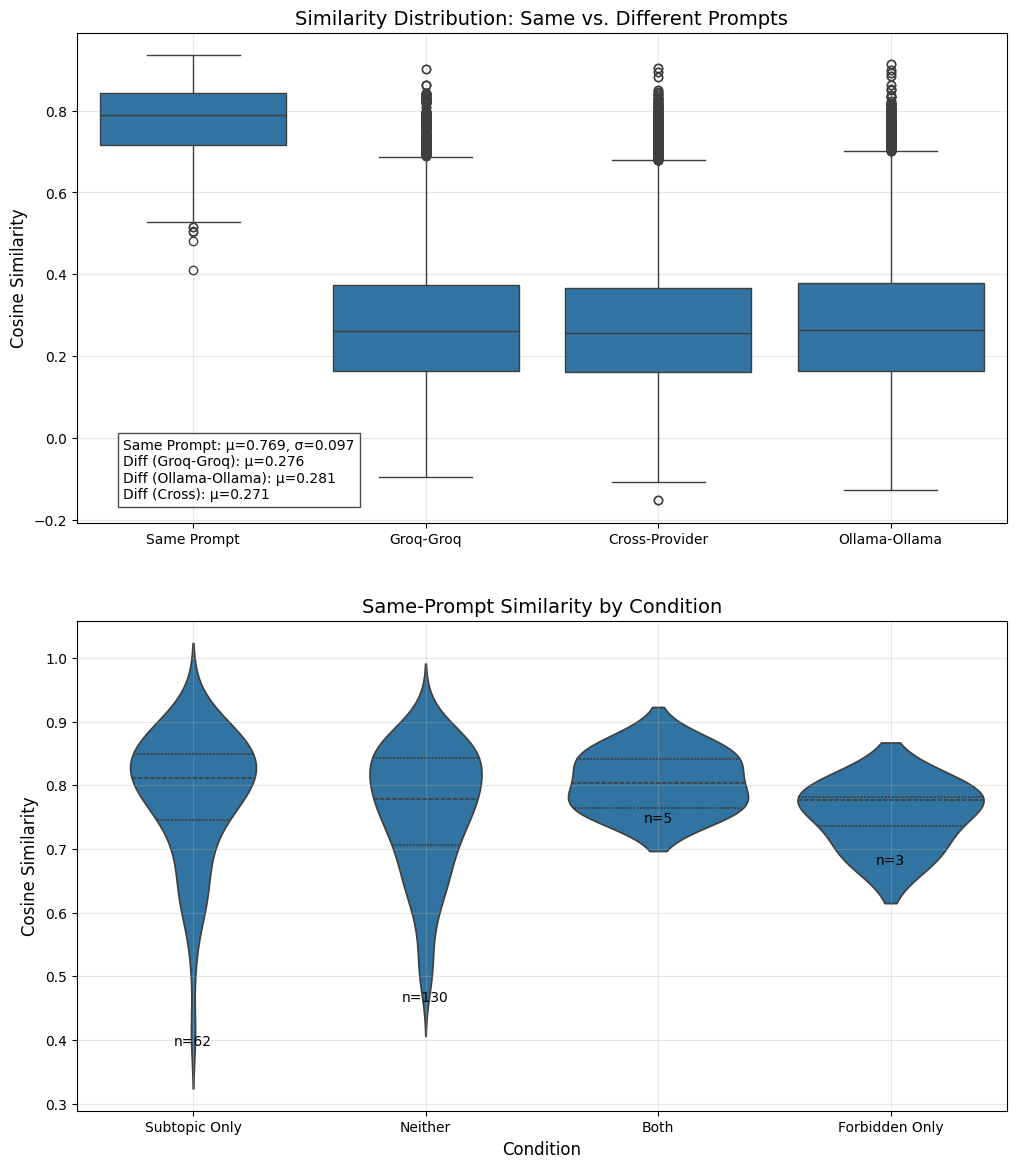

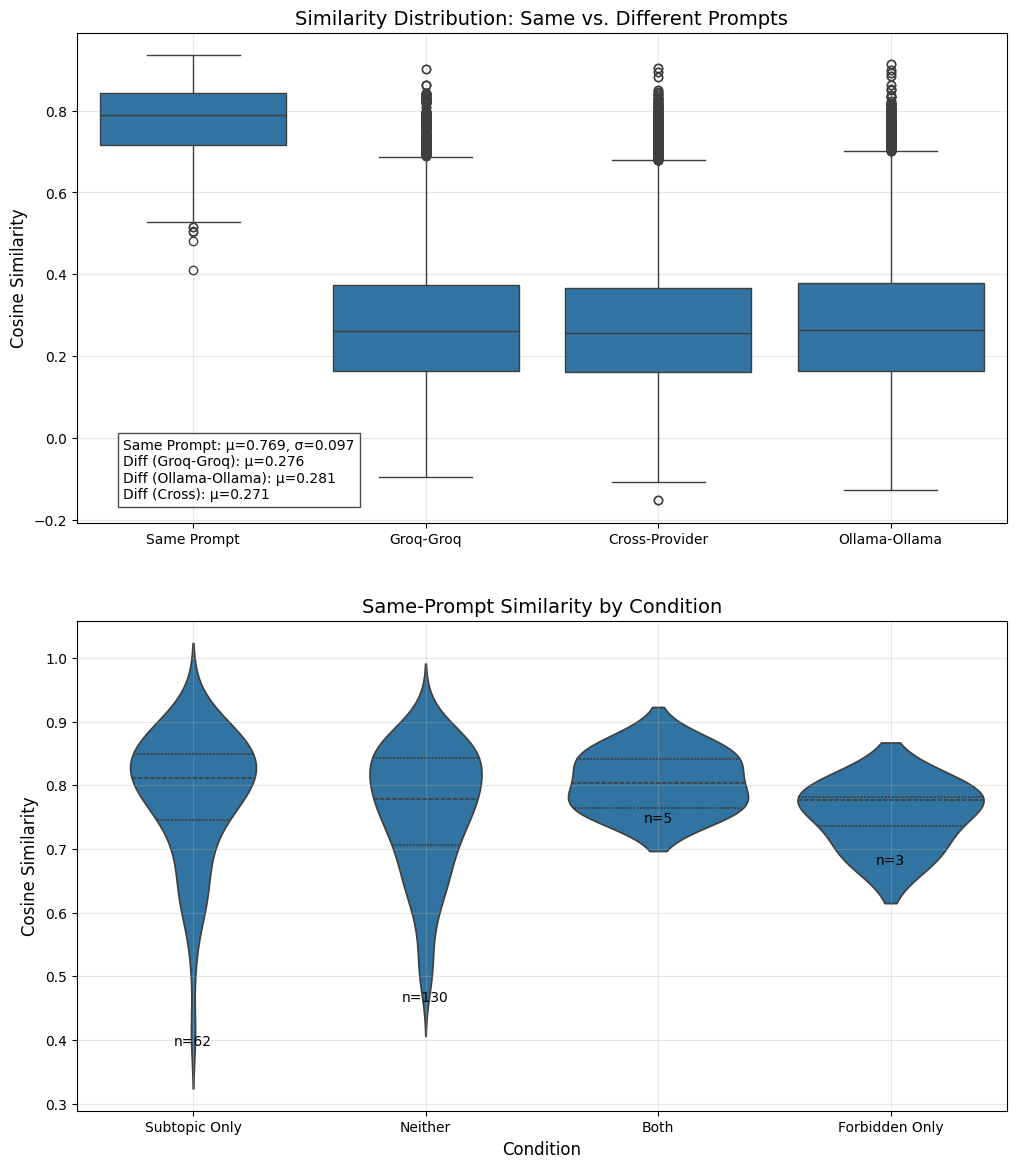

In [30]:
plot_same_vs_different_prompt_similarity(similarity_matrix, metadata)

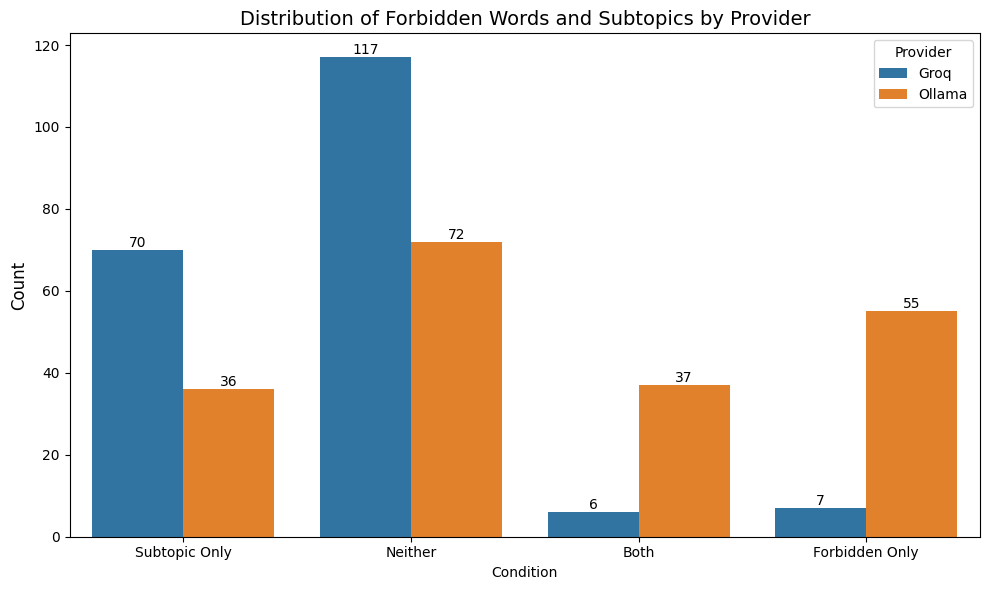

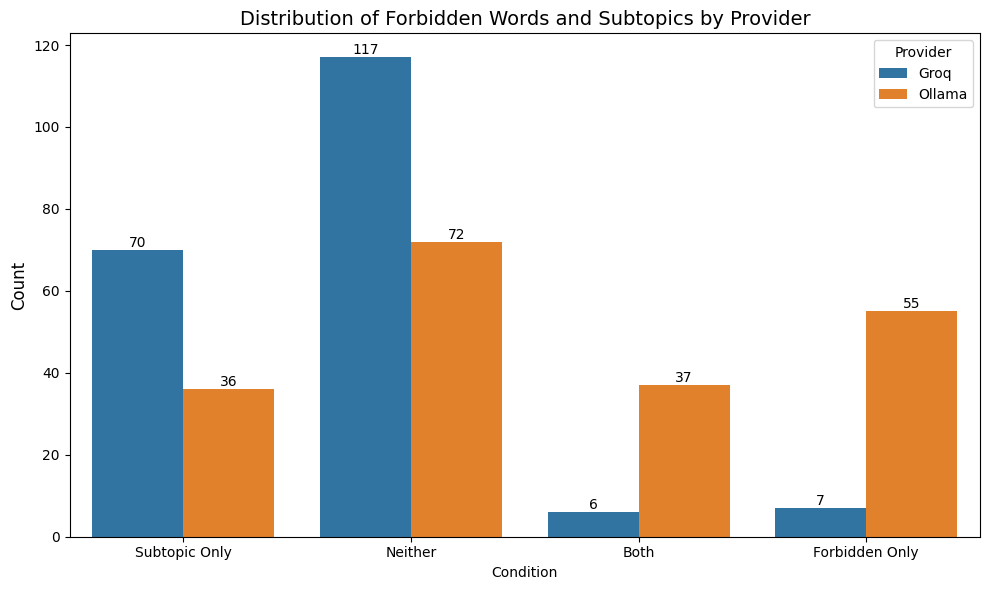

In [33]:
# Plot flag distributions
plot_flag_distributions(flag_data)